In [ ]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
pf.housestyle_rcparams()
import fastkde
from scipy.interpolate import interp1d
from scipy.stats import chi2

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

from scipy.stats import gaussian_kde

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']
folly = '#ff004f'

In [2]:
glob_sigma = 1
glob_bkg = True
glob_pve_bounds = False
glob_det = 'det'

Nsims = 100_000
Nbins = 100
train_bounds = 5

simulator = Simulator_Additive(Nbins=Nbins, sigma=glob_sigma, bounds=train_bounds, 
                               fraction=0.2, bkg=glob_bkg, dtype=torch.float32, 
                               mode='complex', pve_bounds=glob_pve_bounds, bump=glob_det)     
samples = simulator.sample(Nsims=Nsims)  
obs = simulator.sample(1)

In [3]:
p_marker = 'p' if glob_pve_bounds == True else 'n'
b_marker = 'b' if glob_bkg == True else 'q'
d_marker = 'd' if glob_det == 'det' else 's'
# s_marker = '_asymL2'
# m_marker = '_m1' # m0 - plain, m1 - learns binwise mu, m2 - learns theta 
# netid = p_marker+b_marker+d_marker+str(train_bounds)+s_marker+m_marker
netid = p_marker+b_marker+d_marker+str(train_bounds)

if not os.path.isdir('figs/'+netid):
    os.makedirs('figs/'+netid)

/tmp/ipykernel_1570563/600084491.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


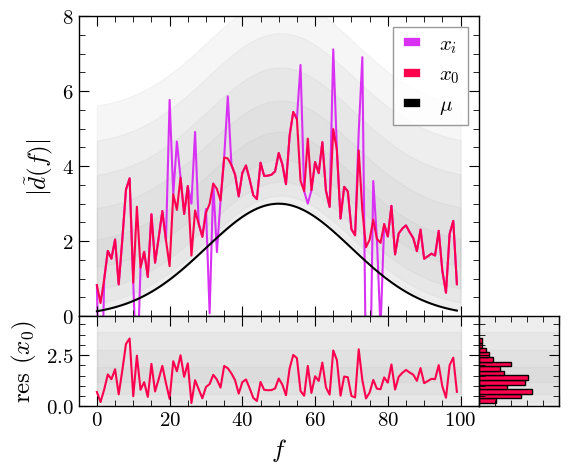

In [4]:
test = simulator.sample(1)
quantiles_long = np.array([7.1508466e-04, 7.9613253e-03, 5.1986761e-02,
       2.1462703e-01, 5.8794379e-01, 1.1776060e+00,
       1.9190179e+00, 2.7507384e+00, 3.6350725e+00,
       4.5491748e+00, 5.4850187e+00], dtype=np.float32)

quantiles = np.array([5.1986761e-02,
       2.1462703e-01, 5.8794379e-01, 1.1776060e+00,
       1.9190179e+00, 2.7507384e+00, 3.6350725e+00], dtype=np.float32)

pf.housestyle_rcparams()
fig, ax1 = pf.create_plot()

plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = fig.add_axes((0,-.3,1,0.3), sharex=ax1)
ax3 = fig.add_axes((1,-.3,0.2,0.3), sharey=ax2)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax1.plot(test['xi'][0], label=r'$x_i$', color="#d931f3")
ax1.plot(test['x0'][0], label=r'$x_0$', color='#ff004f')
ax1.plot(test['mu'][0], label=r'$\mu$', color='black')
ax1.set_ylabel(r'$|\tilde{d}(f)|$')
ax1.set_ylim([0,8])
ax1.legend(loc='upper right')


resd = test['x0'][0]-test['mu'][0]
ax2.plot(resd, color='#ff004f')
ax2.set_xlabel(r'$f$')
ax2.set_ylabel(r'res ($x_0$)')
ax2.set_ylim([0,4.4])
grid = torch.linspace(0, 100, 100)
for i in range(1,6):
    ax1.fill_between(grid, quantiles_long[i]+test['mu'][0], quantiles_long[-i]+test['mu'][0],  color='#b0b0b0', alpha=0.1)
    ax2.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)
    ax3.fill_between(grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.1)

ax3.hist(resd, orientation='horizontal', bins=14, edgecolor='black', color='#ff004f', density=True)
ax3.set_xlim([0,1])

pf.fix_plot([ax1,ax2, ax3])
plt.tight_layout()

In [6]:
nsample = 2**11
nmc = 2**21
numruns = int(nmc/nsample)

x_h0_all = []

for i in tqdm(range(numruns)):
    x_h0_all.append(simulator.sample(nsample)['x0']-simulator.sample(nsample)['mu'])

x_h0_all = torch.concatenate(x_h0_all).flatten()
np.save('../../data_bin/stats_ref/x_h0_all', x_h0_all)

100%|██████████| 1024/1024 [00:08<00:00, 119.11it/s]


In [7]:
# fig, ax1 = pf.create_plot()

# bin_h0 = np.linspace(0,4,50)
# bin_h1 = np.linspace(-4,8,150)

# ax1.hist(x_h0_all, bins=bin_h0, color='#ff004f', alpha=0.4, density=True)
# ax1.hist(x_h0_all, bins=bin_h0, color='black', density=True, histtype='step', linewidth=1)

# ax1.hist(x_h1_all, bins=bin_h1, color='#77aca2', alpha=0.4, density=True, zorder=10)
# ax1.hist(x_h1_all, bins=bin_h1, color='black', density=True, zorder=10, histtype='step', linewidth=1)

# pf.fix_plot([ax1])

In [8]:
kdebloc = np.load('../../data_bin/KDE_ref/KDE_archive.npz')
dat_h0 = kdebloc['dat_h0']+1e-21
dat_h1 = kdebloc['dat_h1']+1e-21

In [9]:
# fig, ax1 = pf.create_plot(size=(4,2))
# ax2 = fig.add_axes((0,1,1,1), sharex=ax1)
# plt.setp(ax2.get_xticklabels(), visible=False)

# grid = np.linspace(-30,30, 1000)
# ti = -2 * (np.log(dat_h0)-np.log(dat_h1))
# t0 = -2 * (np.log(dat_h0)-0)

# ax1.plot(grid,dat_h0, color='#ff004f', label=r'H$_0$', lw=3)
# ax1.plot(grid,dat_h1, color='#77aca2', label=r'H$_i$', lw=3)
# ax1.legend()
# ax1.set_xlim([-7,7])
# ax1.set_ylabel(r'$p(x|...)$')

# ax2.plot(grid,ti, lw=2,color='black')
# ax2.set_ylabel(r'$-2\:\log\frac{p(x|H_i)}{p(x|H_0)}$')

# pf.fix_plot([ax1,ax2])
# plt.tight_layout()
# plt.savefig(f'figs/newkde.png', dpi=700, bbox_inches = 'tight')

/tmp/ipykernel_1570563/2952295213.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


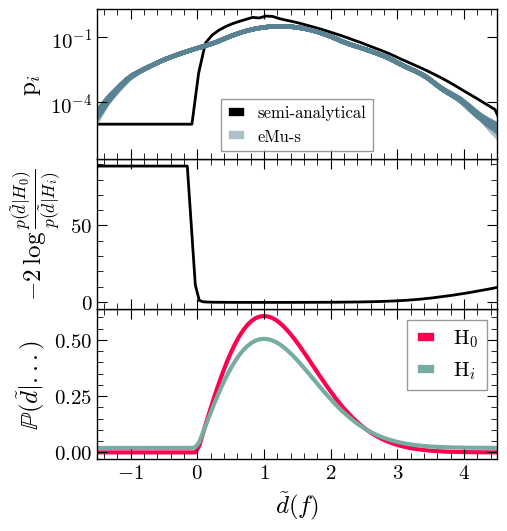

: 

In [ ]:
matrix = np.linspace(-30, 30, 1000)
mask = (matrix >= -2.0) & (matrix <= 4.5)
ti = -2 * (np.log(dat_h0)-np.log(dat_h1))
t_fn = interp1d(matrix[mask], ti[mask], bounds_error=False, fill_value=40.0)
t_samples = t_fn(x_h0_all) 

x_grid = np.linspace(-2, 8.0, 100)
actual_t_values = t_fn(x_grid)
num_extreme_vals_mask = t_samples > actual_t_values[:,
      np.newaxis]
num_extreme_vals = np.sum(num_extreme_vals_mask, axis=1)
p_values = num_extreme_vals / len(t_samples)
p_values[p_values == 0] = 1e-5

fig, ax1 = pf.create_plot(size=(4,1.5))
ax2 = fig.add_axes((0,1,1,1), sharex=ax1)
ax3 = fig.add_axes((0,2,1,1), sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

grid = np.linspace(-30,30, 1000)
ti = -2 * (np.log(dat_h0)-np.log(dat_h1))

ax1.plot(grid,dat_h0, color='#ff004f', label=r'H$_0$', lw=3)
ax1.plot(grid,dat_h1, color='#77aca2', label=r'H$_i$', lw=3)
ax1.legend()
ax1.set_xlim([-1.5,4.5])
ax1.set_xlabel(r'$\tilde{d}(f)$')
ax1.set_ylabel(r'$\mathbb{P}(\tilde{d}|...)$')

ax2.plot(grid,ti, lw=2,color='black')
ax2.set_ylabel(r'$-2\:\log\frac{p(\tilde{d}|H_0)}{p(\tilde{d}|H_i)}$')

ax3.plot(x_grid, p_values, lw=2, color='black', label='semi-analytical')
ax3.set_ylabel(r'p$_i$')
ax3.set_yscale('log')

grid = np.load('data_bin/pvaluegrid.npy')

for i in range(50):
      randbin = np.random.randint(0,100)
      # randbin=0
      randp = grid[:,randbin]
      muat = obs['mu'][0][randbin].numpy()
      amplitudes = np.linspace(-3, 10, 80)-muat
      # ax3.plot(amplitudes, randp, lw=3, color='#598392', label=r'eMu-s'+f', bin {randbin}')
      ax3.plot(amplitudes, randp, lw=3, color='#598392', label=r'eMu-s' if i==0 else None, alpha=0.5)

ax3.legend(fontsize=12)
pf.fix_plot([ax1,ax2,ax3])
plt.tight_layout()
plt.savefig(f'figs/pdf2_log.png', dpi=700, bbox_inches = 'tight')